In [1]:
#from __future__ import division, print_function
import sys
import os
#import json
import csv
import pandas as pd
import numpy as np
import pylab as pl
%pylab inline
#import seaborn
#from scipy.optimize import curve_fit, minimize

import geopandas as gp
from fiona.crs import from_epsg
#import subprocess
import shapely as shp
from datetime import datetime
from itertools import compress
from geopandas.tools import sjoin

Populating the interactive namespace from numpy and matplotlib


In [2]:
cb_2013 = pd.DataFrame()
for m in list(compress(os.listdir('data'), [('cb_2013' in i) for i in os.listdir('data')])):
    cb_2013g = pd.read_csv('data/'+m)
    cb_2013 = cb_2013.append(cb_2013g, ignore_index = True)

In [3]:
# read in 2014 cb data
cb_2014 = pd.DataFrame()
for m in list(compress(os.listdir('data'), [('cb_2014' in i) for i in os.listdir('data')])):
    cb_2014g = pd.read_csv('data/'+m)
    cb_2014 = cb_2014.append(cb_2014g, ignore_index = True)

In [4]:
# read in 2015 cb data
cb_2015 = pd.DataFrame()
for m in list(compress(os.listdir('data'), [('cb_2015' in i) for i in os.listdir('data')])):
    cb_2015g = pd.read_csv('data/'+m)
    cb_2015 = cb_2015.append(cb_2015g, ignore_index = True)

In [5]:
# read in 2016 cb data (to 9/2016)
cb_2016 = pd.DataFrame()
for m in list(compress(os.listdir('data'), [('cb_2016' in i) for i in os.listdir('data')])):
    cb_2016g = pd.read_csv('data/'+m)
    cb_2016 = cb_2016.append(cb_2016g, ignore_index = True)
    
# read in 2016 cb data (10/2016 to end)
cb_2016x = pd.DataFrame()
for m in list(compress(os.listdir('data'), [('cb_x_2016' in i) for i in os.listdir('data')])):
    cb_2016xg = pd.read_csv('data/'+m)
    cb_2016xg.rename(columns={"Trip Duration":"tripduration",
                             "Start Time":"starttime",
                             "Stop Time":"stoptime",
                             "Start Station ID":"start station id",
                             "Start Station Name":"start station name",
                             "Start Station Latitude":"start station latitude",
                             "Start Station Longitude":"start station longitude",
                             "End Station ID":"end station id",
                             "End Station Name":"end station name",
                             "End Station Latitude":"end station latitude",
                             "End Station Longitude":"end station longitude",
                             "Bike ID":"bikeid",
                             "User Type":"usertype",
                             "Birth Year":"birth year",
                             "Gender":"gender"},
               inplace = True)
    cb_2016x = cb_2016x.append(cb_2016xg, ignore_index = True)
    
# append last 3 months to 2016
cb_2016 = cb_2016.append(cb_2016x, ignore_index = True)

In [6]:
def age(dframe):
    dfage = dframe[(dframe['birth year'] >= 2016-65) & (dframe['birth year'] <= 2016-18)]
    dfage = dframe.reset_index(drop = True)
    return dfage


def subs(dframe):
    dfsubs = dframe[dframe['usertype'] == 'Subscriber']
    dfsubs = dfsubs.reset_index(drop = True)
    return dfsubs

def wkdys(dframe):
    dframe['timestamp'] = pd.to_datetime(dframe['starttime'])
    dframe['day'] = dframe['timestamp'].dt.dayofweek 
    dfwkdys = dframe[dframe['day'] <= 4]
    dfwkdys = dfwkdys.reset_index(drop = True)
    return dfwkdys

def hrs(dframe):
    dfhrs = dframe
    dfhrs.index = dfhrs.timestamp
    dfmorn = dfhrs.between_time('7:00:00','10:00:00', include_start=True, include_end=True)
    dfmorn = dfmorn.reset_index(drop = True)
    dfeve = dfhrs.between_time('16:00:00','19:00:00', include_start=True, include_end=True)
    dfeve = dfeve.reset_index(drop = True)
    dfhrs = dfmorn.append(dfeve, ignore_index = True)
    dfhrs = dfhrs.reset_index(drop = True)
    return dfhrs

def dtest(dframe):
    return (dframe.tail(1).index[0]+1, len(dframe),
            dframe['usertype'][dframe['usertype'] == 'Subscriber'].count(),
            dframe['day'][dframe['day'] <= 4].count(),
            dframe['tripduration'][dframe.index.duplicated() == True].count() == 0,
            dframe['birth year'][dframe['birth year'] < 2016-65].count() == 0,
            dframe['timestamp'].dt.hour.unique())


In [7]:
cb_2013 = age(cb_2013)
cb_2013 = wkdys(cb_2013)
cb_2013 = subs(cb_2013)
cb_2013 = hrs(cb_2013)
dtest(cb_2013)

(1668729,
 1668729,
 1668729,
 1668729,
 True,
 True,
 array([ 7,  8,  9, 10, 16, 17, 18, 19]))

In [8]:
cb_2014 = age(cb_2014)
cb_2014 = wkdys(cb_2014)
cb_2014 = subs(cb_2014)
cb_2014 = hrs(cb_2014)
dtest(cb_2014)

(2851564,
 2851564,
 2851564,
 2851564,
 True,
 False,
 array([ 7,  8,  9, 10, 16, 17, 18, 19]))

In [ ]:
cb_2015 = age(cb_2015)
cb_2015 = wkdys(cb_2015)
cb_2015 = subs(cb_2015)
cb_2015 = hrs(cb_2015)
dtest(cb_2015)

In [ ]:
cb_2016 = age(cb_2016)
cb_2016 = wkdys(cb_2016)
cb_2016 = subs(cb_2016)
cb_2016 = hrs(cb_2016)
dtest(cb_2016)

In [ ]:
def stations(dframe):
    cb_stations = dframe[['start station id','start station name','start station latitude','start station longitude']]
    cb_stations.columns = ['station_id','name','lat','lon']
    cb_stations.drop_duplicates(inplace = True)
    cb_stations = cb_stations.reset_index(drop = True)
    return cb_stations

def dups(dframe):
    dupli = dframe[dframe.station_id.duplicated(keep = False)].station_id.unique()
    cb_stations = dframe[[i not in dupli for i in dframe.station_id]]
    cb_stations = cb_stations.reset_index(drop = True)
    return cb_stations

def rides(dframe):
    cb_trips = dframe[['start station id', 'tripduration']]
    cb_trips.columns = ['station_id', 'trips']
    cb_trips = cb_trips.groupby(['station_id'], as_index = False).count()
    return cb_trips

def mrg(dframe, dframe2):
    cbs = dframe.merge(dframe2, how = 'outer', left_on = 'station_id', right_on = 'station_id')
    cbs = cbs.dropna()
    return cbs

def geoc(dframe):
    dframe['lonlat']=zip(dframe.lon, dframe.lat)
    dframe['geometry']=dframe[['lonlat']].applymap(lambda x:shp.geometry.Point(x))
    cbs = dframe[['station_id', 'trips', 'geometry']]
    return cbs

def bufs(dframe):
    geo_dframe = gp.GeoDataFrame(dframe, geometry = 'geometry')
    geo_dframe.crs = {'init' :'epsg:4326'}
    #geo_dframe = geo_dframe.to_crs(epsg=2263) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
    geo_dframe = geo_dframe.to_crs(epsg=4326)
    return geo_dframe

In [ ]:
stations_2013 = stations(cb_2013)
stations_2013 = dups(stations_2013)
rides_2013 = rides(cb_2013)
stations_2013 = mrg(stations_2013,rides_2013)
stations_2013 = geoc(stations_2013)
stations_2013 = bufs(stations_2013)
stations_2013.tail(2)

In [ ]:
stations_2014 = stations(cb_2014)
stations_2014 = dups(stations_2014)
rides_2014 = rides(cb_2014)
stations_2014 = mrg(stations_2014,rides_2014)
stations_2014 = geoc(stations_2014)
stations_2014 = bufs(stations_2014)
stations_2014.tail(2)

In [ ]:
stations_2015 = stations(cb_2015)
stations_2015 = dups(stations_2015)
rides_2015 = rides(cb_2015)
stations_2015 = mrg(stations_2015,rides_2015)
stations_2015 = geoc(stations_2015)
stations_2015 = bufs(stations_2015)
stations_2015.tail(2)

In [ ]:
stations_2016 = stations(cb_2016)
stations_2016 = dups(stations_2016)
rides_2016 = rides(cb_2016)
stations_2016 = mrg(stations_2016,rides_2016)
stations_2016 = geoc(stations_2016)
stations_2016 = bufs(stations_2016)
stations_2016.tail(2)

In [ ]:
all_stations = pd.DataFrame()
all_stations = stations_2013
all_stations = all_stations.append(stations_2014,ignore_index = True)
all_stations = all_stations.append(stations_2015,ignore_index = True)
all_stations = all_stations.append(stations_2016,ignore_index = True)
all_stations = all_stations.reset_index(drop = True)
all_stations.drop_duplicates(inplace = True)
dups(all_stations)
dtest(all_stations)

In [388]:
#from geopandas import GeoDataFrame
shape_path="ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

from fiona.crs import from_epsg
ct_shape.crs = from_epsg(2263) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
#NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
#print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet
ct_shape.crs = ct_shape.to_crs(epsg=2263)

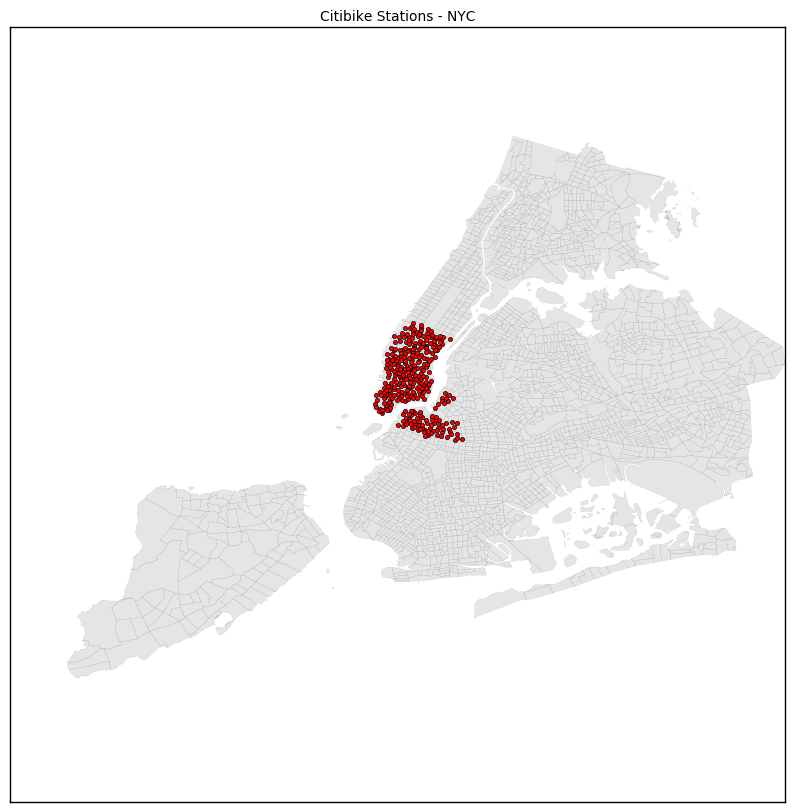

In [397]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=.2,color='grey',linewidth=0.03,ax=ax)
all_stations.geometry.plot(markersize=3,color='red',label = 'Stations', ax=ax)
plt.title("Citibike Stations - NYC", fontsize = 10)
#plt.ylabel('Longitude', fontsize = 15)
#plt.xlabel('Latitude', fontsize = 15)